In [ ]:
!pip install torch

In [5]:
from model import unet_model
import tensorflow as tf
import glob
from functools import partial
from utils import dice_coef, dice_bce_loss
import matplotlib
import numpy as np

In [99]:
tf.config.list_physical_devices("GPU")

[]

In [98]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [96]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [27]:
#Зададим размер batch и размер изображения
BATCH_SIZE = 16
IMG_SHAPE  = (256, 256)
OUTPUT_SIZE = (960, 1280)

CLASSES = 8

#Цвета для отображения сегментации
Colors = ['black',
          'blue',
          'green',
          'sky',
          'red',
          'pink',
          'yellow',
          'white']
rgb_colors = [(0, 0, 0),
              (0, 0, 1),
              (0, 1, 1),
              (0, 1, 1),
              (1, 0, 0),
              (1, 0, 1),
              (1, 1, 0),
              (1, 1, 1)]
color_desc=["Background",
              "Human drivers",
              "Plants and grass",
              "Wrecks and ruins",
              "Robots",
              "Reefs and invertebrates",
              "Fish and vertebrates",
              "Sea-floor and roocks",]

original = tf.constant(rgb_colors)
original = tf.cast(original, tf.float32)
rgb_colors_tf = tf.image.rgb_to_grayscale(original)
rgb_colors_converted= rgb_colors_tf.numpy().reshape(-1,).tolist()

In [8]:
images = sorted(glob.glob('./dataset/images/*.jpg'))
masks = sorted(glob.glob('./dataset/masks/*.bmp'))

In [9]:
#Функция для загрузки изображения
def load_img(image, mask):
    #Загружаем и препроцессим изображения
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, IMG_SHAPE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0

    #Загружаем и препроцессим маски изображений
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_bmp(mask)
    mask = tf.image.resize(mask, IMG_SHAPE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = mask / 255.
    mask = tf.image.rgb_to_grayscale(mask)

    #Сохраним маски для каждого класса
    masks = []
    for color in rgb_colors_converted:
        masks.append(tf.where(tf.equal(mask, float(color)), 1.0, 0.0))
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, IMG_SHAPE + (CLASSES,))
    return image, masks

#Аугментация изобажений
def aug_img(image, masks):
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    image = tf.image.resize(image, IMG_SHAPE)
    masks = tf.image.resize(masks, IMG_SHAPE)
    return image, masks

In [10]:
#Формируем датасет
dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images),
                               tf.data.Dataset.from_tensor_slices(masks)))

#Загружаем дату
dataset = dataset.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)

#Аугментация (увеличим датасет в 50 раз)
# dataset = dataset.repeat(50)
# dataset = dataset.map(aug_img, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
#Размер train выборки
train_size = 1200

#Делим на train и test
train_dataset = dataset.take(train_size).cache()
test_dataset = dataset.skip(train_size).take(len(dataset) - train_size).cache()

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
#Функция для подсчёта DICE коэффициента
def dice_coef(y_pred, y_true):
    y_pred = tf.unstack(y_pred, axis=3)
    y_true = tf.unstack(y_true, axis=3)
    dice_summ = 0

    for i, (a_y_pred, b_y_true) in enumerate(zip(y_pred, y_true)):
        dice_calculate = (2 * tf.math.reduce_sum(a_y_pred * b_y_true) + 1) /\
         (tf.math.reduce_sum(a_y_pred + b_y_true) + 1)

        dice_summ += dice_calculate
    avg_dice = dice_summ/CLASSES
    return avg_dice


#Функция для подсчета DICE loss
def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss


#binary_crossentropy - дает хорошую сходимость модели при сбалансированном наборе данных
#DICE - хорошо в задачах сегментации но плохая сходимость
#Плохо сбалансированные данные, но хорошие реузьтаты:
# Binary crossentropy + 0.25 * DICE

def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [58]:
def my_dice_loss(y_pred, y_true):
    multipl = tf.math.reduce_sum(tf.math.multiply(y_pred, y_true), axis=[0,1])
    divider = tf.math.reduce_sum(y_pred**2, axis=[0, 1])+tf.math.reduce_sum(y_true**2, axis=[0, 1])
    return tf.math.reduce_mean(1-2*multipl/divider)

In [91]:
import keras
#Иницилизируем модель
model = unet_model(IMG_SHAPE, CLASSES)

# tf.keras.utils.plot_model(model, show_shapes=True)
lr=1e-4
optimizer = keras.optimizers.Adam(learning_rate=lr)
#Компилируем модель
model.compile(optimizer=optimizer,
                  loss=[my_dice_loss],
                  metrics=[dice_coef, dice_bce_loss])

In [92]:
EPOCHS = 20

#Обучение
model.fit(train_dataset,
          # validation_data=test_dataset,
          epochs=EPOCHS,
          initial_epoch=0)
model.save('./checkpoints/unet_20epochs_mydice')

Epoch 1/20


2023-11-22 11:58:45.374063: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


39/75 [==============>...............] - ETA: 2:46 - loss: 0.7398 - dice_coef: 0.1847 - dice_bce_loss: 0.9028

KeyboardInterrupt: 

In [14]:
model = tf.keras.models.load_model('./checkpoints/unet_150', custom_objects={"dice_coef": dice_coef, "dice_bce_loss":dice_bce_loss})

2023-11-22 11:32:53.666523: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2023-11-22 11:32:53.683154: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2023-11-22 11:32:53.705252: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2023-11-22 11:32:53.731276: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2023-11-22 11:32:53.753167: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.


In [18]:
# Преобразование Датасета
test_dataset_ex = None
test_dataset_img = None

for el in test_dataset.unbatch().as_numpy_iterator():
    test_dataset_img = np.append(test_dataset_img, [el[0]], axis=0) if test_dataset_img is not None else np.array([el[0]])
    test_dataset_ex = np.append(test_dataset_ex, [el[1]], axis=0) if test_dataset_ex is not None else np.array([el[1]])

In [19]:
test_results = model.predict(test_dataset_img)

11/11 [==============================] - 26s 2s/step


In [20]:
test_results.shape

(325, 256, 256, 8)

In [21]:
iou_data = np.zeros((test_results.shape[0], test_results.shape[-1]))

smooth=1

for img, idx in zip(test_dataset.unbatch(), range(test_results.shape[0])):  # Итерация по изображениям
    y = img[1]    
    for f in range(test_results.shape[-1]):  # Итерация по каналам
        # iou_data = np.append(iou_data, IoU_calc(y[..., f].numpy(), test_results[idx][..., f]))
        
        flat_pred = y[..., f].numpy().ravel()
        flat_target = test_results[idx][..., f].ravel()
        
        intersection = (flat_pred * flat_target).sum()
        total = (flat_pred + flat_target).sum()
        union = total - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_data[idx, f] = iou

In [22]:
iou_data.mean()

0.3845083058564074

In [23]:
iou_data.mean(axis=0).reshape(-1,1)

array([[0.55949603],
       [0.51044783],
       [0.30423466],
       [0.30423515],
       [0.95698103],
       [0.15927513],
       [0.09427357],
       [0.18712306]])

In [26]:
import matplotlib.pyplot as plt
def img_show(*images, **kwargs):
    title = None
    if kwargs.get("titles", False):
            title = kwargs.pop("titles")
    
    fig, axs = plt.subplots(1, len(images), figsize=(18, 5))
    for idx, el in enumerate(zip(axs, images)):
        ax, img = el
        ax.imshow(img, **kwargs)
        if title:
            ax.set_title(title[idx]) 

In [86]:
def my_dice_loss(y_pred, y_true):
    multipl = tf.math.reduce_sum(tf.math.multiply(y_pred, y_true), axis=[0,1])
    divider = tf.math.reduce_sum(y_pred**2, axis=[0, 1])+tf.math.reduce_sum(y_true**2, axis=[0, 1])
    return tf.math.reduce_mean(1-2*multipl/divider)

In [87]:
my_dice_loss(test_results[img_index], test_dataset_ex[img_index])

<tf.Tensor: shape=(), dtype=float32, numpy=0.7265432>

In [81]:
a=tf.math.reduce_sum(tf.math.multiply(test_results[img_index], test_dataset_ex[img_index]), axis=[0,1])

In [82]:
b=tf.math.reduce_sum(test_results[img_index]**2, axis=[0, 1])+tf.math.reduce_sum(test_dataset_ex[img_index]**2, axis=[0, 1])

In [83]:
1-2*a/b

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.99417067, 1.        , 1.        , 1.        , 1.        ,
       0.22007567, 0.5438727 , 0.0542264 ], dtype=float32)>

In [84]:
tf.math.reduce_mean(1-2*a/b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7265432>

In [71]:
tf.math.reduce_sum(y_pred**2, axis=[0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=13938.429>

In [52]:
tf.math.multiply(test_results[img_index], test_dataset_ex[img_index])

<tf.Tensor: shape=(256, 256, 8), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.29522240e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.63241923e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.56816542e-01, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.38537437e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.00549832e-02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.76419048e-02, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.95648015e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.96146393e-01, 0.0

In [51]:
tf.math.reduce_sum(test_dataset_ex[img_index]**2, axis=[0, 1])

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([  124.,     0.,     0.,     0.,     0., 24009.,  4444., 36248.],
      dtype=float32)>

In [48]:
test_dataset_ex[img_index].shape

(256, 256, 8)

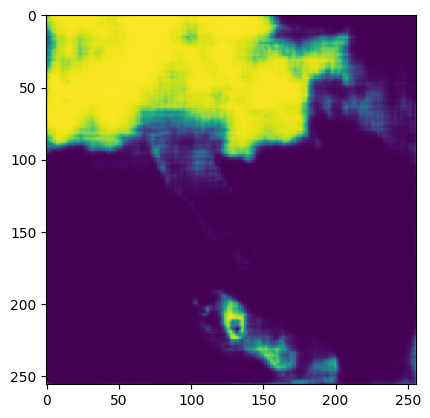

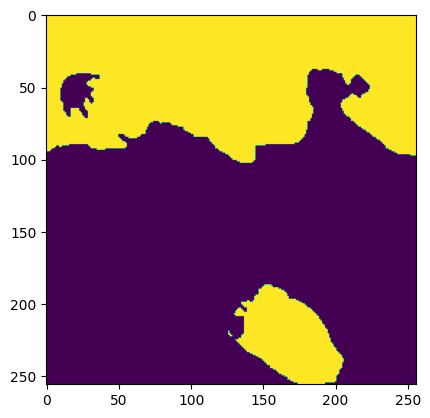

In [75]:
img_index=1
y_true=test_dataset_ex[img_index][..., 5]
y_pred=test_results[img_index][..., 5]
plt.imshow(y_pred)
plt.show()
plt.imshow(y_true)
plt.show()

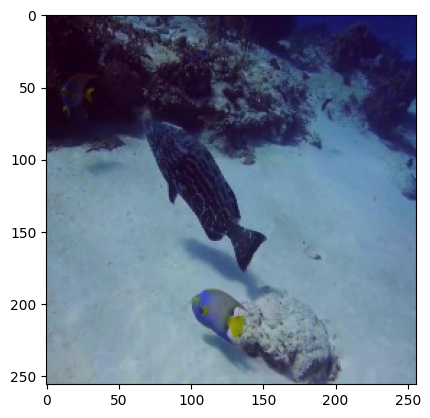

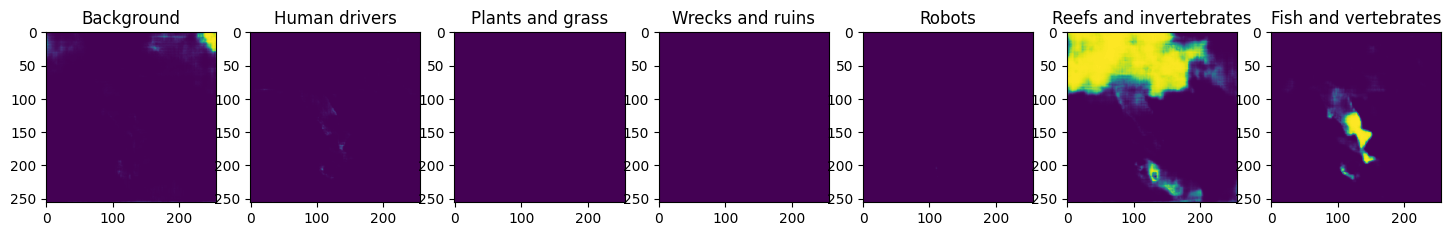

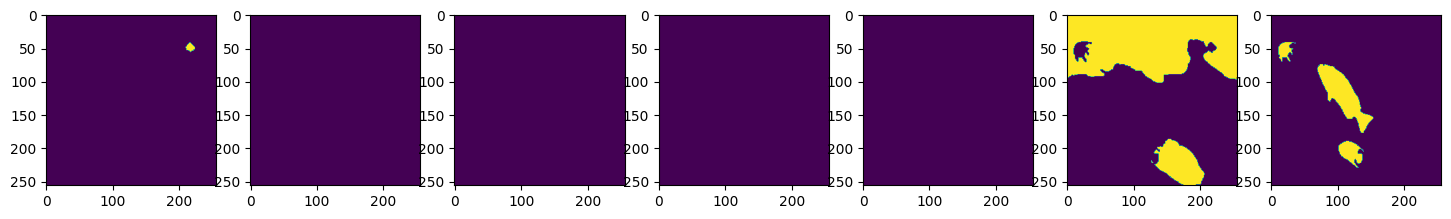

In [235]:
img_index = 1
plt.imshow(test_dataset_img[img_index], )
img_show(*[test_results[img_index][..., i] for i in range(7)], titles=color_desc)
img_show(*[test_dataset_ex[img_index][..., i] for i in range(7)])

In [232]:
a = tf.constant([[[[1, 2], 
                   [2, 4]], 
                  [[5, 6], 
                   [3, 4]],
                  [[7, 2], 
                   [3, 3]]], 
                 
                 [[[3, 0], 
                   [0, 0]], 
                  [[3, 0], 
                   [3, 3]],
                  [[7, 2], 
                   [3, 3]]]])

In [234]:
a.T

AttributeError: EagerTensor object has no attribute 'T'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [161]:
tf.constant([[[0, 0], [0, 1]], [[1, 1], [1, 0]]])

<tf.Tensor: shape=(2, 2, 2), dtype=int32, numpy=
array([[[0, 0],
        [0, 1]],

       [[1, 1],
        [1, 0]]], dtype=int32)>

In [129]:
tf.reduce_max(a, axis=-1, keepdims=True)

<tf.Tensor: shape=(2, 2, 1), dtype=int32, numpy=
array([[[ 2],
        [ 4]],

       [[ 6],
        [-3]]], dtype=int32)>

In [163]:
tf.reduce_max(a, axis=2, keepdims=True)

<tf.Tensor: shape=(2, 2, 1), dtype=int32, numpy=
array([[[ 2],
        [ 4]],

       [[ 6],
        [-3]]], dtype=int32)>

In [205]:
c = a == tf.reduce_max(a, axis=1, keepdims=True)
c

<tf.Tensor: shape=(2, 2, 2, 2), dtype=bool, numpy=
array([[[[False, False],
         [False,  True]],

        [[ True,  True],
         [ True,  True]]],


       [[[ True,  True],
         [False,  True]],

        [[ True,  True],
         [ True, False]]]])>

In [231]:
tf.math.reduce_all(
    c, axis=1, keepdims=True
)

<tf.Tensor: shape=(2, 1, 2, 2), dtype=bool, numpy=
array([[[[False, False],
         [False,  True]]],


       [[[ True,  True],
         [False, False]]]])>

In [230]:
tf.math.logical_not(tf.math.reduce_all(
    c, axis=1, keepdims=True
))

<tf.Tensor: shape=(2, 1, 2, 2), dtype=bool, numpy=
array([[[[ True,  True],
         [ True, False]]],


       [[[False, False],
         [ True,  True]]]])>

In [216]:
tf.math.logical_and(tf.math.logical_not(tf.math.reduce_all(
    c, axis=1, keepdims=True
)), c)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=bool, numpy=
array([[[[False, False],
         [False, False]],

        [[ True,  True],
         [ True, False]]],


       [[[False, False],
         [False,  True]],

        [[False, False],
         [ True, False]]]])>

In [166]:
a

<tf.Tensor: shape=(2, 2, 2), dtype=int32, numpy=
array([[[ 1,  2],
        [-5,  4]],

       [[ 5,  6],
        [-3, -4]]], dtype=int32)>

In [167]:
treshhold=2

In [178]:
a * tf.cast(a>treshhold,"int32")

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int32, numpy=
array([[[[0, 0],
         [0, 4]],

        [[5, 6],
         [0, 0]]],


       [[[0, 0],
         [0, 4]],

        [[5, 6],
         [0, 0]]]], dtype=int32)>

In [193]:
tf.cast(a>treshhold,"float32")

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float32, numpy=
array([[[[0., 0.],
         [0., 1.]],

        [[1., 1.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]], dtype=float32)>

In [180]:
a.dtype

tf.int32

In [208]:
a = tf.constant([[[[1, 2], [2, 4]], [[5, 6], [3, 4]]], [[[3, 0], [0, 4]], [[3, 0], [3, 3]]]])
a

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int32, numpy=
array([[[[1, 2],
         [2, 4]],

        [[5, 6],
         [3, 4]]],


       [[[3, 0],
         [0, 4]],

        [[3, 0],
         [3, 3]]]], dtype=int32)>

In [242]:
def get_mask(y_pred, treshhold=0.5, axis=1):
    """
    if y_pred has batch (batch, X, Y, c), then axis=1, else (X, Y, c) axis=0
    """
    y_type = y_pred.dtype
    mask = y_pred*tf.cast(y_pred>treshhold, y_type)
    mask = tf.cast(mask == tf.reduce_max(mask, axis=axis, keepdims=True), y_type)
    return mask

In [238]:
b = get_mask(a, 2)

In [239]:
a

<tf.Tensor: shape=(2, 3, 2, 2), dtype=int32, numpy=
array([[[[1, 2],
         [2, 4]],

        [[5, 6],
         [3, 4]],

        [[7, 2],
         [3, 3]]],


       [[[3, 0],
         [0, 0]],

        [[3, 0],
         [3, 3]],

        [[7, 2],
         [3, 3]]]], dtype=int32)>

In [240]:
b

<tf.Tensor: shape=(2, 3, 2, 2), dtype=int32, numpy=
array([[[[0, 0],
         [0, 1]],

        [[0, 1],
         [1, 1]],

        [[1, 0],
         [1, 0]]],


       [[[0, 1],
         [0, 0]],

        [[0, 1],
         [1, 1]],

        [[1, 1],
         [1, 1]]]], dtype=int32)>

In [255]:
tf.reduce_max(test_dataset_ex[img_index], axis=-1, keepdims=True)

<tf.Tensor: shape=(256, 256, 1), dtype=float32, numpy=
array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)>

In [247]:
test_dataset_ex[img_index]>0.5

array([[[False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False]],

       [[False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False]],

       [[False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, Fal

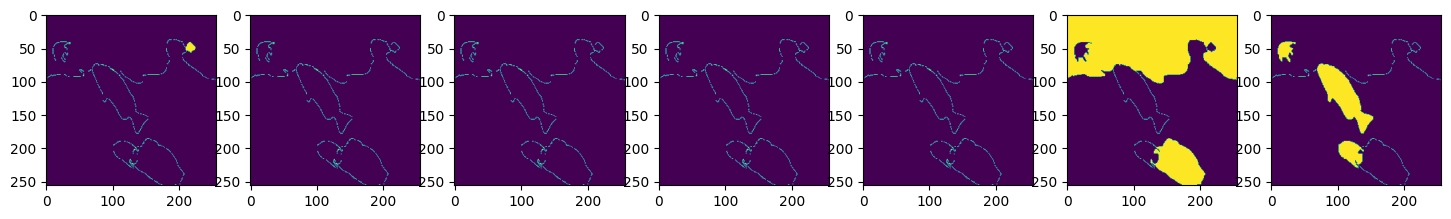

In [263]:
img_show(*[get_mask(test_dataset_ex[img_index], axis=-1)[..., i] for i in range(7)])

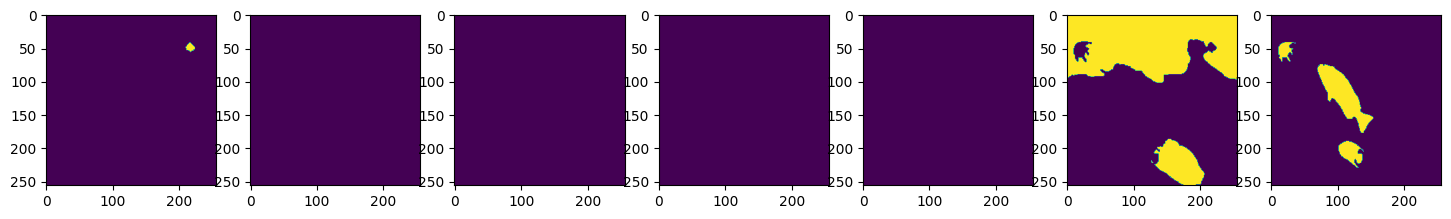

In [262]:
img_show(*[test_dataset_ex[img_index][..., i] for i in range(7)])